In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from scipy.interpolate import interp1d
import sys
sys.path.append('C:/Users/pedro/OneDrive/Escritorio/Projects/DRAGON2/')
from utils_CR import CR

# DATA EXTRACTION

In [3]:
aD_path = "C:/Users/pedro/OneDrive/Escritorio/Projects/DRAGON2/Antiprotons/Antinuclei/Antinuc_runs/"
Desktop_path = 'C:/Users/pedro/OneDrive/Escritorio/'

In [4]:
FILE = aD_path + '/run_2D_AntiD_XSconstraints_spectrum.fits.gz'  #-NoPenalties

print(FILE)

hdulist = fits.open(FILE) 
#hdulist.info() 
prihdr = hdulist[0].header  # the primary header 
n_ext  = len(hdulist)


table_hdu    = hdulist[0]              
table_header = table_hdu.header     # header attribute of TABLE 
print(table_header['zmin'], table_header['zmax'], table_header['rmin'], table_header['rmax'], table_header['izsun'], 
      table_header['irsun'], table_header['dimz'], table_header['dimr'], table_header['robs'], table_header['zobs'])
#print(hdulist[10].header)

emin   = table_header['ekmin']
ek_fac = table_header['ekin_fac']
dimE   = table_header['dimE'] 

E = [emin*(ek_fac**i) for i in range(0,dimE)]
E = np.array(E)

table_H1_P, table_H1_S, table_H2, table_H3, table_He4, table_He3 = [], [], [], [], [], []
table_sec_pos, table_pri_ele, table_sec_ele, table_ext, table_lept = [], [], [], [], []
table_apro_S, table_apro_P, table_aD_S, table_aD_P, table_aD_DM = [], [], [], [], []
table_aHe_S, table_aHe_P, table_aHe_DM = [], [], []
for i in range(1,n_ext): #points in the list         
        
    if hdulist[i].header['A'] == 1 and hdulist[i].header['Z_'] == 1 and hdulist[i].header['SEC'] == 0 :
        table_H1_P.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 1 and hdulist[i].header['Z_'] == 1 and hdulist[i].header['SEC'] == 1 :
        table_H1_S.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 2 and hdulist[i].header['Z_'] == 1 :
        table_H2.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 3 and hdulist[i].header['Z_'] == 1 :
        table_H3.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 4 and hdulist[i].header['Z_'] == 2 :
        table_He4.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 3 and hdulist[i].header['Z_'] == 2 :
        table_He3.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 1 and hdulist[i].header['Z_'] == -1 and hdulist[i].header['SEC'] == 0 :
        table_apro_P.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 1 and hdulist[i].header['Z_'] == -1  and hdulist[i].header['SEC'] == 1:
        table_apro_S.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 2 and hdulist[i].header['Z_'] == -1 and hdulist[i].header['SEC'] == 0 and hdulist[i].header['DM'] == 0:
        table_aD_P.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 2 and hdulist[i].header['Z_'] == -1  and hdulist[i].header['SEC'] == 1 and hdulist[i].header['DM'] == 0:
        table_aD_S.append(hdulist[i].data)    
    elif hdulist[i].header['A'] == 2 and hdulist[i].header['Z_'] == -1  and hdulist[i].header['DM'] == 1:
        #print(hdulist[i].header)
        table_aD_DM.append(hdulist[i].data)
        
    elif hdulist[i].header['A'] == 3 and hdulist[i].header['Z_'] == -2 and hdulist[i].header['SEC'] == 0 and hdulist[i].header['DM'] == 0:
        table_aHe_P.append(hdulist[i].data)
    elif hdulist[i].header['A'] == 3 and hdulist[i].header['Z_'] == -2  and hdulist[i].header['SEC'] == 1 and hdulist[i].header['DM'] == 0:
        table_aHe_S.append(hdulist[i].data)    
    elif hdulist[i].header['A'] == 3 and hdulist[i].header['Z_'] == -2  and hdulist[i].header['DM'] == 1:
        #print(hdulist[i].header)
        table_aHe_DM.append(hdulist[i].data)
        
        
table_H1 = np.array(table_H1_P) + np.array(table_H1_S)
table_Ap = np.array(table_apro_P) + np.array(table_apro_S)
table_Ad = np.array(table_aD_P) + np.array(table_aD_S) + np.sum(table_aD_DM, 0)
table_AHe = np.array(table_aHe_P) + np.array(table_aHe_S) + np.sum(table_aHe_DM, 0)

C:/Users/pedro/OneDrive/Escritorio//run_2D_AntiD_XSconstraints_spectrum.fits.gz
-4.72 4.72 0.0 20.0 40 33 81 81 8.3 0.0


In [5]:
phi_ams = 0.61  ## Fisk potential adopted to make the plots 
phi_neg = 0.9
phi_App = 0.58 

#params for the plots
widths = [1]
heights = [2.8,1.]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

## For Voyager data
def voyerr(a, b, da, db):
    if ((type(a) != np.ndarray) or (type(b) != np.ndarray) or 
        (type(da) != np.ndarray) or (type(db) != np.ndarray)):
        print("Error, the Fluxes (Energies) and errFluxes (ErrEnergies) must be an array")
    return np.sqrt((da/b)**2 + (-a*db/b**2)**2)

data_path = 'C:/Users/pedro/OneDrive/Escritorio/Projects/DRAGON2/data_files'

# He & H

In [6]:
data = data_path + '/prot&Hel/prot_AMS_2011-2013.dat'
Emeanp, Emeanp_low, Emeanp_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxp, fluxp_low, fluxp_up = np.loadtxt(data,skiprows=0,usecols=(3, 8, 9), unpack=True)
errfluxp = (fluxp_low + fluxp_up)/2

data = data_path + '/prot&Hel/He_AMS_2011-2013.dat'
EmeanHe, EmeanHe_low, EmeanHe_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxHe, fluxHe_low, fluxHe_up = np.loadtxt(data,skiprows=0,usecols=(3, 8, 9), unpack=True)
errfluxHe = (fluxHe_low + fluxHe_up)/2

<ipython-input-7-c4a253503abd>:8: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  frame1.set_xscale('log', nonposx = 'clip')


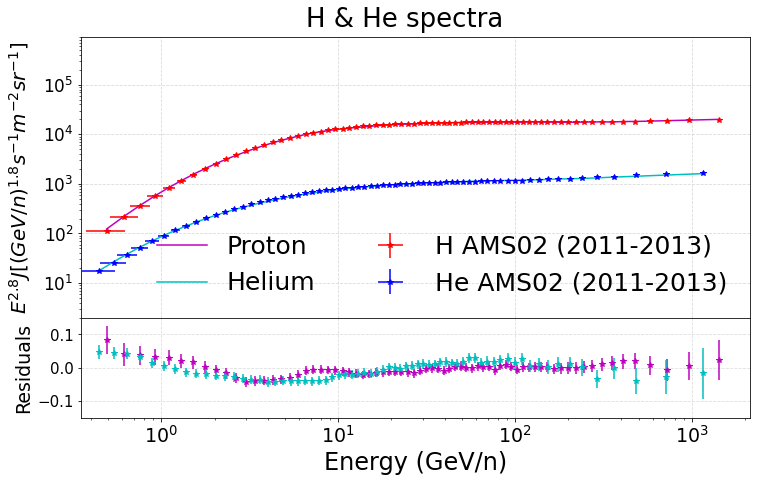

In [7]:
slope = 2.8

fig1, (frame1,frame2)=plt.subplots(2, sharex='col', figsize=(12,7), gridspec_kw=gs_kw)
fig1.suptitle("H & He spectra", fontsize = 26, y=0.94)
    
fig1.subplots_adjust(hspace=0.)
frame1.set_yscale('log')
frame1.set_xscale('log', nonposx = 'clip')

frame1.errorbar(Emeanp, fluxp*np.power(Emeanp, slope), xerr = [(Emeanp-Emeanp_low)/Emeanp, (Emeanp_up-Emeanp)/Emeanp], yerr = [fluxp_low*np.power(Emeanp, slope), fluxp_up*np.power(Emeanp, slope)], fmt= '*r', label = "H AMS02 (2011-2013)") #Real data

frame1.errorbar(EmeanHe, fluxHe*np.power(EmeanHe, slope), xerr = [(EmeanHe-EmeanHe_low)/EmeanHe, (EmeanHe_up-EmeanHe)/EmeanHe], yerr = [fluxHe_low*np.power(EmeanHe, slope), fluxHe_up*np.power(EmeanHe, slope)], fmt= '*b', label = "He AMS02 (2011-2013)") #Real data

H1 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H1)[0], 1, 1, phi_ams-0.01))
H2 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H2)[0], 1, 2, phi_ams-0.01))
H3 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H3)[0], 1, 3, phi_ams-0.01))
mod0 = H1 + H2 + H3

frame1.plot(Emeanp, mod0*(Emeanp**slope), "m-", label='Proton')

He3 = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He3)[0], 2, 3, phi_ams-0.01))
He4 = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He4)[0], 2, 4, phi_ams-0.01))
mod1 = He4 + He3

frame1.plot(EmeanHe, mod1*(EmeanHe**slope), "c-", label='Helium')


frame1.set_ylabel(r"$E^{2.8} J [(GeV/n)^{1.8} s^{-1} m^{-2} sr^{-1}]$", fontsize = 20, labelpad = 10)
frame1.tick_params(axis = 'y', labelsize=17)
frame1.grid(color = '0.85', linestyle='dashed')
frame1.set_ylim(bottom = 2, top = 9e5)
frame1.set_xlim(left = 0.35)#, right = 2000)
frame1.legend(fontsize = 25, loc = 4, ncol = 2, frameon = False)

frame2.set_xscale("log")

diff = np.array(mod0-fluxp)
frame2.errorbar(Emeanp, diff/mod0, yerr = [(fluxp_up/fluxp), (fluxp_low/fluxp)],  fmt= "m*")

diff = np.array(mod1-fluxHe)
frame2.errorbar(EmeanHe, diff/mod1, yerr = [(fluxHe_up/fluxHe), (fluxHe_low/fluxHe)], fmt= "c*")


frame2.set_ylabel("Residuals", fontsize = 19)
frame2.set_xlabel("Energy (GeV/n)", fontsize = 24)
frame2.set_xlim(left = 0.35)#, right = 1800)
frame2.grid(color = '0.87', linestyle='dashed')
plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
frame2.set_ylim(bottom = -0.15, top = 0.15)
#frame2.legend(ncol = 4, loc = 0) #1 is upper right
#plt.tight_layout()
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/pHe_spectrum.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/pHe_spectrum.pdf')
plt.show()
plt.close()

In [8]:
data = data_path + '/prot&Hel/Voyager1_2012_Proton.dat'
EmeanVp, EmeanVp_low, EmeanVp_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxVp, fluxVp_low, fluxVp_up = np.loadtxt(data,skiprows=0,usecols=(3, 8, 9), unpack=True)
errfluxVp = (fluxVp_low + fluxVp_up)/2

data = data_path + '/prot&Hel/Voyager_He_2012.dat'
EmeanVHe, EmeanVHe_left, EmeanVHe_right = np.loadtxt(data,skiprows=0,usecols=(0,1, 2), unpack = True)
fluxVHe, fluxVHe_low, fluxVHe_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)    
errfluxVHe = (fluxVHe_low + fluxVHe_up)/2

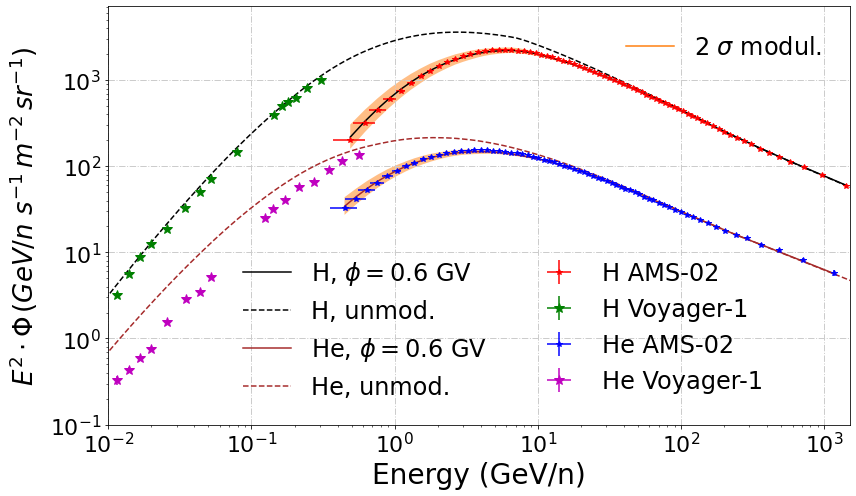

In [9]:
sloppe = 2.

fig1 = plt.figure(figsize=(12,7))
#fig1.suptitle("H & He spectra", fontsize = 26, y=0.94)
plt.yscale('log')
plt.xscale('log')

plt.errorbar(Emeanp, fluxp*Emeanp**sloppe, yerr = [fluxp_low*Emeanp**2, fluxp_up*Emeanp**sloppe], xerr = [(Emeanp - Emeanp_low)/Emeanp, (Emeanp_up-Emeanp)/Emeanp], fmt='*r', label = r"H AMS-02") #(2011-2013)
plt.errorbar(EmeanVp, fluxVp*np.power(EmeanVp, sloppe), xerr = [(EmeanVp-EmeanVp_low)/EmeanVp, (EmeanVp_up-EmeanVp)/EmeanVp], yerr = [fluxVp_low*np.power(EmeanVp, sloppe), fluxVp_up*np.power(EmeanVp, sloppe)], fmt= '*g', label = r"H Voyager-1", markersize = 10.)
plt.errorbar(EmeanHe,fluxHe*EmeanHe**sloppe, xerr = [(EmeanHe - EmeanHe_low)/EmeanHe, (EmeanHe_up-EmeanHe)/EmeanHe], yerr = [fluxHe_low*EmeanHe**sloppe, fluxHe_up*EmeanHe**sloppe], fmt='*b', label = r"He AMS-02") # (2011-2013)
plt.errorbar(EmeanVHe, fluxVHe*np.power(EmeanVHe, sloppe), xerr = [(EmeanVHe-EmeanVHe_left)/EmeanVHe, (EmeanVHe_right-EmeanVHe)/EmeanVHe], yerr = (errfluxVHe/fluxVHe)**sloppe, fmt= '*m', label = r"He Voyager-1", markersize = 10.)

####### Protons #####
H1 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H1)[0], 1, 1, phi_ams-0.011))
H2 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H2)[0], 1, 2, phi_ams-0.011))
H3 = np.interp(Emeanp, E, CR.modul(E, np.array(table_H3)[0], 1, 3, phi_ams-0.011))
mod1 = (H1 + H2 + H3)
plt.plot(Emeanp, mod1*(Emeanp**sloppe), "k-", label = r"H, $\phi = {}$ GV".format(str(phi_ams-0.01)))

H1_ = np.interp(Emeanp, E, CR.modul(E, np.array(table_H1)[0], 1, 1, phi_ams-0.011+0.12))
H2_ = np.interp(Emeanp, E, CR.modul(E, np.array(table_H2)[0], 1, 2, phi_ams-0.011+0.12))
H3_ = np.interp(Emeanp, E, CR.modul(E, np.array(table_H3)[0], 1, 3, phi_ams-0.011+0.12))
mod1sup  = (H1_ + H2_ + H3_)*(Emeanp**sloppe)
H1_ = np.interp(Emeanp, E, CR.modul(E, np.array(table_H1)[0], 1, 1, phi_ams-0.011-0.12))
H2_ = np.interp(Emeanp, E, CR.modul(E, np.array(table_H2)[0], 1, 2, phi_ams-0.011-0.12))
H3_ = np.interp(Emeanp, E, CR.modul(E, np.array(table_H3)[0], 1, 3, phi_ams-0.011-0.12))
mod1low  = (H1_ + H2_ + H3_)*Emeanp**(sloppe)
plt.fill_between(Emeanp, mod1sup, mod1low, facecolor='C1', alpha=0.5)#, label = r"2 $\sigma$ modul.")

mod0 = (np.array(table_H1)[0] + np.array(table_H2)[0] + np.array(table_H3)[0])*(E**sloppe)
plt.semilogx(E, mod0, "k", linestyle='dashed', label = "H, unmod.")


####### HELIUM #####
He3 = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He3)[0], 2, 3, phi_ams-0.01))
He4 = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He4)[0], 2, 4, phi_ams-0.01))
plt.plot(EmeanHe, (He4 + He3)*(EmeanHe**sloppe), "brown", linestyle='solid', label = r"He, $\phi = {}$ GV".format(str(phi_ams-0.01)))

He3_ = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He3)[0], 2, 3, phi_ams-0.01+0.12))
He4_ = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He4)[0], 2, 4, phi_ams-0.01+0.12))
mod1supHe  = (He3_ + He4_)*(EmeanHe**sloppe)
He3_ = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He3)[0], 2, 3, phi_ams-0.01-0.12))
He4_ = np.interp(EmeanHe, E, CR.modul(E, np.array(table_He4)[0], 2, 4, phi_ams-0.01-0.12))
mod1lowHe  = (He3_ + He4_)*(EmeanHe**sloppe)
plt.fill_between(EmeanHe, mod1supHe, mod1lowHe, facecolor='C1', alpha=0.5)

mod0He = (np.array(table_He3)[0] + np.array(table_He4)[0])*(E**sloppe)
plt.semilogx(E, mod0He, "brown", linestyle='dashed', label = "He, unmod.")


leg = fig1.legend(labels=[ "2 $\sigma$ modul."], ncol = 1, fontsize = 24, frameon = False, loc = (0.72, 0.86)) 
LH = leg.legendHandles
LH[0].set_color('C1')
plt.legend(prop={'size': 24}, frameon = False, ncol = 2, loc = [0.15, 0.003], fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel(r"$E^{2} \cdot \Phi \, (GeV$/$n  \,\,s^{-1} \, m^{-2} \, sr^{-1})$", fontsize = 26, labelpad = 10)
plt.xlabel("Energy (GeV/n)", fontsize = 28)
plt.xlim(right = 1.5e3, left = 0.01)
plt.ylim(bottom = 1.e-1)
plt.grid(color = '0.8', linestyle='-.', linewidth=1)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.tight_layout()
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/pHe_Mod_Fluka.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/pHe_Mod_Fluka.pdf')
plt.show()
plt.close()

# ANTIPROTONS

In [10]:
data = data_path + '/prot&Hel/pbar_AMS02_2018.txt' #Antip_AMS_2011-2015.dat'
Rmeana, Rmeana_left, Emeana_right = np.loadtxt(data,skiprows=0,usecols=(0,1, 2), unpack = True)
fluxa, fluxa_low, fluxa_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)                
errfluxa = (fluxa_low + fluxa_up)/2
EmeanAp, yAp, errAp = CR.Rig_to_En(Rmeana, 1, 1, fluxa, (fluxa_low + fluxa_up)/2)

data = data_path + '/prot&Hel/Antip_PAM_JETPlett2013.txt'
EmeanaP, EmeanaP_left, EmeanaP_right = np.loadtxt(data,skiprows=0,usecols=(0,1, 2), unpack = True)
fluxaP, fluxaP_low, fluxaP_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxaP = (fluxaP_low + fluxaP_up)/2

# #### Aprot/prot DATA
print(r"\n $\hat{p}$/p \n")
data = data_path + '/prot&Hel/pbar_p_AMS_PRL2018.txt'
RmeanApp, RminApp, RmaxApp = np.loadtxt(data,skiprows=2,usecols=(0,1,2),unpack=True)
fluxApp, fluxApp_low, fluxApp_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
EmeanApp, yApp, errApp = CR.Rig_to_En(RmeanApp, 1, 1, fluxApp, (fluxApp_low + fluxApp_up)/2)
RmeanAAp, yAAp, erAAp = CR.En_to_Rig(EmeanApp, 1, 1, yApp, errApp)

data = data_path + '/prot&Hel/pbar_p_PAM_JETPlett2013.txt'
EmeanrP, EminrP,EmaxrP = np.loadtxt(data,skiprows=2,usecols=(0,1,2),unpack=True)
fluxrP, fluxrP_low, fluxrP_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)

\n $\hat{p}$/p \n


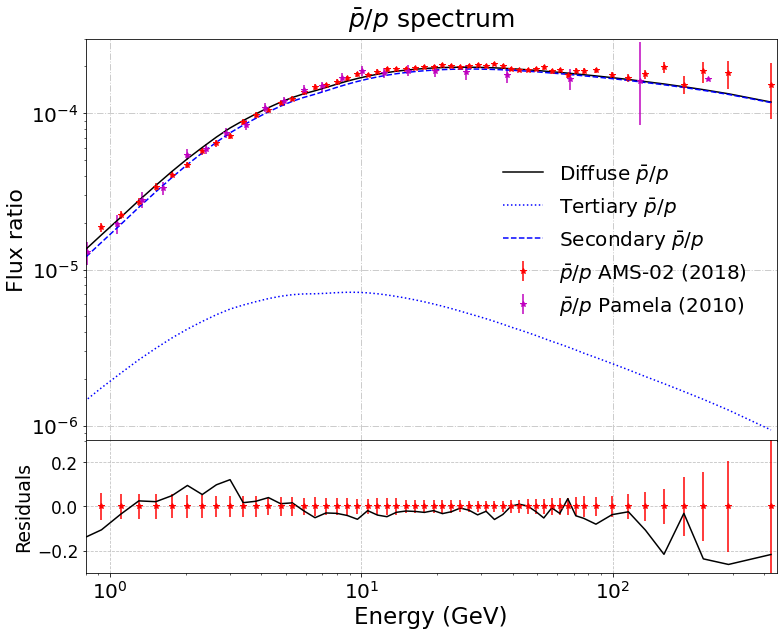

In [11]:
#PLOT
fig1 = plt.figure(figsize=(12., 9.))
fig1.suptitle(r'$\bar{p}/p$ spectrum', fontsize = 25, y = 0.97) #
#Plot Data and model
frame1=fig1.add_axes((.1,.3,.8,.62)) #xmin, ymin, dx, dy
plt.yscale('log')

frame1.errorbar(EmeanApp, yApp, yerr = errApp, fmt='*r', label = r"$\bar{p}/p$ AMS-02 (2018)") #Real data
frame1.errorbar(EmeanrP, fluxrP, yerr = [fluxrP_low, fluxrP_up], fmt='*m', label = r"$\bar{p}/p$ Pamela (2010)") #Real data


H1 = np.interp(EmeanApp, E, CR.modul(E, np.array(table_H1)[0], 1, 1, phi_App))
H2 = np.interp(EmeanApp, E, CR.modul(E, np.array(table_H2)[0], 1, 2, phi_App))
H3 = np.interp(EmeanApp, E, CR.modul(E, np.array(table_H3)[0], 1, 3, phi_App))
AP = np.interp(EmeanApp, E, CR.modul(E, np.array(table_Ap)[0], 1, 1, phi_App, Antip=True, phi_n = phi_neg))
modApp = AP/(H1 + H2 + H3)
plt.semilogx(EmeanApp, modApp, 'k', label =  r"Diffuse $\bar{p}/p$")


APtert = np.interp(EmeanApp, E, CR.modul(E, np.array(table_apro_S)[0], 1, 1, phi_App, Antip=True, phi_n = phi_neg))
modAppTert = APtert/(H1 + H2 + H3)
plt.semilogx(EmeanApp, modAppTert, 'b', linestyle='dotted', label =  r"Tertiary $\bar{p}/p$")

APsec = np.interp(EmeanApp, E, CR.modul(E, np.array(table_apro_P)[0], 1, 1, phi_App, Antip=True, phi_n = phi_neg))
modAppsec = APsec/(H1 + H2 + H3)
plt.semilogx(EmeanApp, modAppsec, 'b', linestyle = 'dashed', label =  r"Secondary $\bar{p}/p$")

'''
H1 = np.interp(EmeanApp, E, CR.modul(E, np.array(table_H1)[0], 1, 1, 0))
H2 = np.interp(EmeanApp, E, CR.modul(E, np.array(table_H2)[0], 1, 2, 0))
H3 = np.interp(EmeanApp, E, CR.modul(E, np.array(table_H3)[0], 1, 3, 0))
AP = np.interp(EmeanApp, E, CR.modul(E, np.array(table_Ap)[0], 1, 1, 0, Antip=True, phi_n = 0))
mod0App = Ap_sc*AP/(H1 + H2 + H3)
plt.semilogx(EmeanApp, mod0App, 'k', linestyle = 'dashed', label =  r"Diffuse $\bar{p}/p, unmod.$")
'''

frame1.legend(prop={'size': 20}, frameon = False, loc = 0, fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.ylabel("Flux ratio", fontsize = 22)
frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)
frame1.set_ylim(bottom = 8e-7, top = 3e-4)
plt.xlim(left = 0.8, right = 450)


frame2 = fig1.add_axes((.1,.096,.8,.205))
plt.xscale('log')

frame2.errorbar(EmeanApp, np.zeros(len(EmeanApp)), yerr = errApp/yApp, fmt = "r*", label = "AMS-02 error-bars")

diff = np.array(modApp-yApp)
frame2.plot(EmeanApp, diff/yApp, "k")

frame2.set_ylim(top = 0.3, bottom = -0.3)
frame2.yaxis.set_tick_params(labelsize = 17)
plt.xlim(left = 0.8, right = 450)
frame2.xaxis.set_tick_params(labelsize = 20)

frame2.set_ylabel("Residuals", fontsize = 19)
frame2.set_xlabel("Energy (GeV)", fontsize = 23)

#frame2.set_yticks([-0.4, -0.2, 0.0, 0.2])
frame2.grid(color= '0.76', linestyle='dashed')#color='w', linestyle='solid')

#plt.legend(ncol = 2, loc = 0, frameon=True, borderpad=1) #1 is upper right
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/App.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/App.pdf')
plt.show()
plt.close()



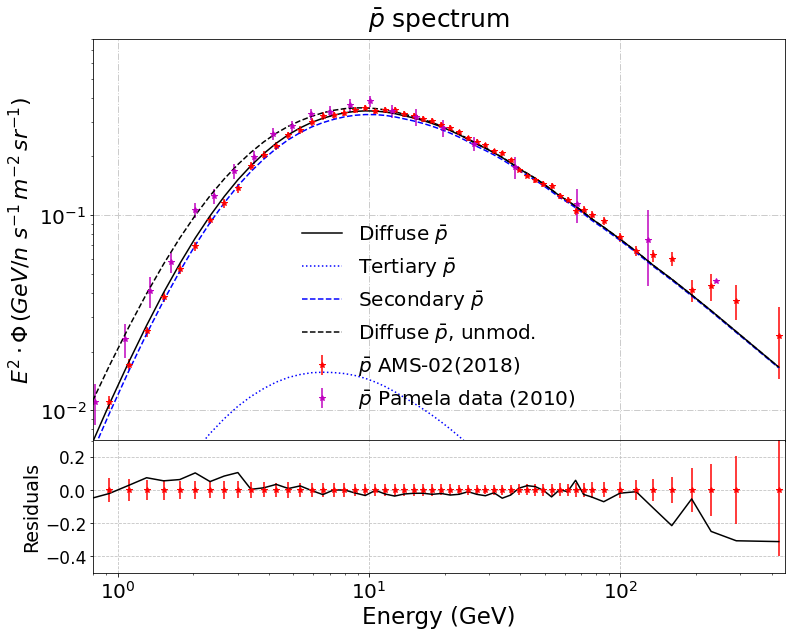

In [12]:
slopp = 2.

#PLOT
fig1 = plt.figure(figsize=(12., 9.))
fig1.suptitle(r'$\bar{p}$ spectrum', fontsize = 25, y = 0.97) #
#Plot Data and model
frame1=fig1.add_axes((.1,.3,.8,.62)) #xmin, ymin, dx, dy
plt.yscale('log')

frame1.errorbar(EmeanAp, yAp*EmeanAp**slopp, yerr = errAp*EmeanAp**slopp, fmt='*r', label = r"$\bar{p}$ AMS-02(2018)") #Real data
frame1.errorbar(EmeanaP, fluxaP*EmeanaP**slopp, yerr = [fluxaP_low*EmeanaP**slopp, fluxaP_up*EmeanaP**slopp], fmt='*m', label = r"$\bar{p}$ Pamela data (2010)") #Real data



modAp = np.interp(EmeanAp, E, CR.modul(E, np.array(table_Ap)[0], 1, 1, phi_App, Antip=True, phi_n = phi_neg))
plt.semilogx(EmeanAp, modAp*EmeanAp**slopp, 'k', label =  r"Diffuse $\bar{p}$")

APtert = np.interp(EmeanAp, E, CR.modul(E, np.array(table_apro_S)[0], 1, 1, phi_App, Antip=True, phi_n = phi_neg))
plt.semilogx(EmeanAp, APtert*EmeanAp**slopp, 'b', linestyle='dotted', label =  r"Tertiary $\bar{p}$")

APsec = np.interp(EmeanAp, E, CR.modul(E, np.array(table_apro_P)[0], 1, 1, phi_App, Antip=True, phi_n = phi_neg))
plt.semilogx(EmeanAp, APsec*EmeanAp**slopp, 'b', linestyle='dashed', label =  r"Secondary $\bar{p}$")


mod0Ap = np.interp(EmeanAp, E, CR.modul(E, np.array(table_Ap)[0], 1, 1, phi_App, Antip=True, phi_n = 0))
plt.semilogx(EmeanAp, mod0Ap*EmeanAp**slopp, 'k', linestyle = 'dashed', label =  r"Diffuse $\bar{p}$, unmod.")

frame1.legend(prop={'size': 20}, frameon = False, loc = 0, fancybox=True, framealpha=1, shadow=True, borderpad=1)

if slopp == 2.:
    plt.ylabel(r"$E^{2} \cdot \Phi \, (GeV$/$n  \,\,s^{-1} \, m^{-2} \, sr^{-1})$", fontsize = 22)
else: 
    raise SystemExit("Change the label for this slopp value ({})".format(slopp))

frame1.grid(color = '0.8', linestyle='-.', linewidth=1)
frame1.yaxis.set_tick_params(labelsize = 20)
frame1.set_ylim(bottom = 7e-3, top = 0.8)
plt.xlim(left = 0.8, right = 450)


frame2 = fig1.add_axes((.1,.096,.8,.205))
plt.xscale('log')

frame2.errorbar(EmeanAp, np.zeros(len(EmeanAp)), yerr = errAp/yAp, fmt = "r*", label = "AMS-02 error-bars")

diff = np.array(modAp-yAp)
frame2.plot(EmeanApp, diff/yAp, "k")

frame2.set_ylim(top = 0.3, bottom = -0.5)
frame2.yaxis.set_tick_params(labelsize = 17)
plt.xlim(left = 0.8, right = 450)
frame2.xaxis.set_tick_params(labelsize = 20)

frame2.set_ylabel("Residuals", fontsize = 19)
frame2.set_xlabel("Energy (GeV)", fontsize = 23)

frame2.set_yticks([-0.4, -0.2, 0.0, 0.2])

#frame2.set_yticks([0.05, -0.05], minor=True)
#frame2.yaxis.grid(True, which='minor', color = 'chocolate', linestyle='-.', linewidth=1)
frame2.grid(color= '0.76', linestyle='dashed')#color='w', linestyle='solid')

#plt.legend(ncol = 2, loc = 0, frameon=True, borderpad=1) #1 is upper right
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Ap.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Ap.pdf')
plt.show()
plt.close()

# ANTIDEUTERONS

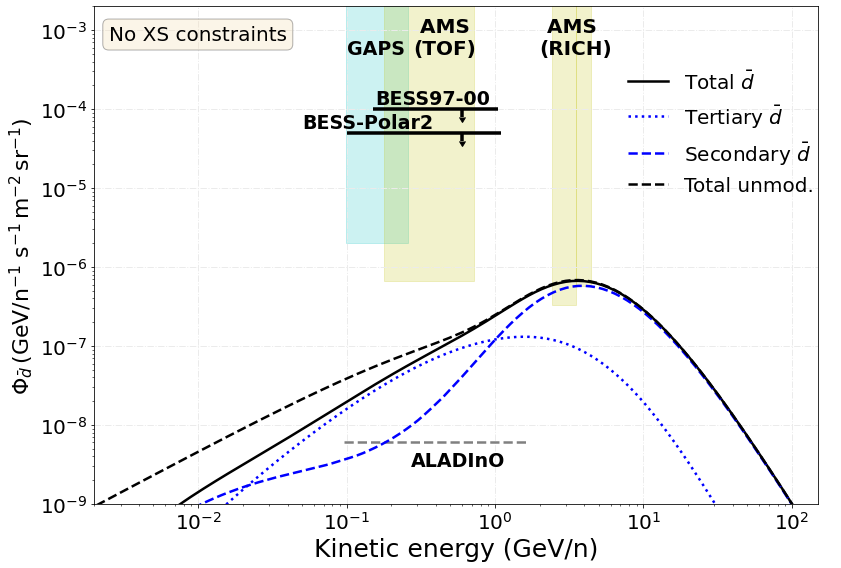

In [16]:
slopp = 0.

#PLOT
fig1 = plt.figure(figsize=(12., 8.))
#fig1.suptitle(r'$\bar{d}$ spectrum', fontsize = 25, y = 0.95) #
#Plot Data and model
plt.yscale('log')
plt.xscale('log')

plt.fill_between([0.0996, 0.2608], [2e-6, 2e-6], [10, 10], color='c', alpha=0.2) # GAPS
plt.fill_between([0.178, 0.7176], [2e-6/3, 2e-6/3], [10, 10], color='y', alpha=0.2)  # AMS Divided by 3 to have 15 years!!
plt.fill_between([2.4094, 3.528], [1e-6/3, 1e-6/3], [10, 10], color='y', alpha=0.2)  # AMS
plt.fill_between([3.52896, 4.45173], [1.72e-6/3, 1.72e-6/3], [10, 10], color='y', alpha=0.2)  # AMS

plt.errorbar(0.6, 1e-4, xerr = 0.45, yerr = 2e-5, uplims= 1, lolims= 0, color='k', lw=3.5)  # BESS97
plt.errorbar((0.1+1.5)/2 - 0.2, 5e-5, xerr = 0.5, yerr = 1e-5, uplims= 1, lolims= 0, color='k', lw=3.5)  # BESS-Polar2
plt.axhline(y = 6.e-9, xmin = 0.345, xmax = 0.6, color = 'grey', linestyle = '--', linewidth = 2.5)

plt.text(0.1, 0.0005, "GAPS", fontsize = 19, fontweight='bold')
plt.text(0.28, 0.0005, " AMS\n(TOF)", fontsize = 20, fontweight='bold')
plt.text(2.0, 0.0005, " AMS\n(RICH)", fontsize = 20, fontweight='bold')
plt.text(0.155, 0.000115, "BESS97-00", fontsize = 19, fontweight='bold')
plt.text(0.05, 0.000057, "BESS-Polar2", fontsize = 19, fontweight='bold')
plt.text(0.27, 3e-9, "ALADInO", fontsize = 19, fontweight='bold')  #5 years!

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.0025, 7.5e-4, "No XS constraints", fontsize = 20, bbox=props)



modAd = CR.modul(E, np.array(table_Ad)[0], 1, 2, phi_App, Antip=True, phi_n = phi_neg)
plt.semilogx(E, modAd*E**slopp, 'k', label =  r"Total $\bar{d}$", lw=2.5)

ADtert = CR.modul(E, np.array(table_aD_S)[0], 1, 2, phi_App, Antip=True, phi_n = phi_neg)
plt.semilogx(E, ADtert*E**slopp, 'b', linestyle='dotted', label =  r"Tertiary $\bar{d}$", lw=2.5)

ADsec = CR.modul(E, np.array(table_aD_P)[0], 1, 2, phi_App, Antip=True, phi_n = phi_neg)
plt.semilogx(E, ADsec*E**slopp, 'b', linestyle='dashed', label =  r"Secondary $\bar{d}$", lw=2.5)


mod0Ad = CR.modul(E, np.array(table_Ad)[0], 1, 2, phi_App, Antip=True, phi_n = 0)
plt.semilogx(E, mod0Ad*E**slopp, 'k', linestyle = 'dashed', label =  r"Total unmod.", lw=2.5)

plt.legend(prop={'size': 20}, frameon = False, ncol = 1, loc = [0.71, 0.58], fancybox=True, framealpha=1, shadow=True, borderpad=1)

if slopp == 2.:
    plt.ylabel(r"$E^{2} \cdot \Phi_{\bar{d}} \, $(GeV/n$  \,\,$s$^{-1} \, $m$^{-2} \, $sr$^{-1}$)", fontsize = 22)
elif slopp == 0.:
    plt.ylabel(r"$\Phi_{\bar{d}} \, $(GeV/n$^{-1}  \,\,$s$^{-1} \, $m$^{-2} \, $sr$^{-1}$)", fontsize = 22)
else: 
    raise SystemExit("Change the label for this slopp value ({})".format(slopp))

plt.tick_params(labelsize = 20)
plt.xlabel("Kinetic energy (GeV/n)", fontsize=25)
plt.ylim(bottom = 1e-9, top = 2e-3)
plt.xlim(left = 0.002, right = 150)
plt.grid(color = '0.92', linestyle='-.', linewidth=1)

plt.tight_layout()
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Ad-NoPenalties.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Ad-NoPenalties.pdf')
plt.show()
plt.close()



# $\bar{^3He}$

In [17]:
AMS_10yr = np.array([9.28555503630024E-08, 5.29498512325043E-08, 9.45741609003175E-09, 1.59754369665382E-08, 1.85568495098897E-08, 2.32317269928308E-08, 2.69856569534712E-08, 2.9084308668979E-08, 3.01940673937511E-08, 2.9084308668979E-08, 2.59938207805806E-08, 2.15553830830402E-08, 1.92649160444003E-08, 1.72178331866347E-08, 1.22917189445832E-08, 1.01929113398171E-08, 7.2766648426669E-09, 4.47213595499957E-09, 2.74851191204102E-09, 1.75365082623691E-09, 1.07776915415201E-09, 1.82056420302608E-09, 4.1494376952347E-09, 2.85338581876656E-09, 1.82056420302608E-09, 1.16158634964154E-09, 1.07776915415201E-09, 0.000000001, 1.68919679693236E-09, 2.15553830830402E-08, 8.94427190999916E-08])
E_AMS10 = np.array([0.129477, 0.129477743473502, 0.130940251495589, 0.196192737428011, 0.248383047457735, 0.321600765018994, 0.407151554778968, 0.521282530344724, 0.667406210913565, 0.873903371067406, 1.19687495821794, 1.4983378692733, 1.9840882063016, 2.84222553294827, 3.76365456364458, 4.76484503122481, 6.10050593058833, 9.34827990096256, 12.6601550451822, 16.5772388558931, 24.8383047457735, 25.4025929280683, 25.9797008722564, 34.7907198392808, 46.0696204357025, 58.3248537588689, 63.8084285011759, 67.4944857411923, 67.4944857411923, 67.4944857411923, 67.49449])

### DM models

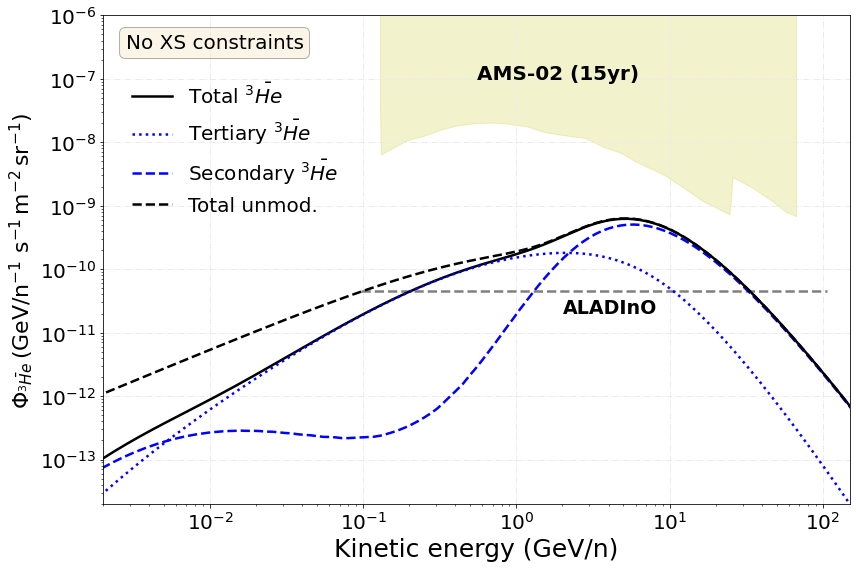

In [25]:
slopp = 0.

#PLOT
fig1 = plt.figure(figsize=(12., 8.))
#fig1.suptitle(r'$\bar{d}$ spectrum', fontsize = 25, y = 0.95) #
#Plot Data and model
plt.yscale('log')
plt.xscale('log')

#plt.fill_between(E_AMS5, AMS_5yr/3, np.ones(len(E_AMS5)), color='y', alpha=0.2)  # AMS
plt.fill_between(E_AMS10, 2*AMS_10yr/3, np.ones(len(E_AMS10)), color='y', alpha=0.2)
plt.axhline(y = 4.5e-11, xmin = 0.345, xmax = 0.97, color = 'grey', linestyle = '--', linewidth = 2.5)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.5, 1.e-7, " AMS-02 (15yr)", fontsize = 20, fontweight='bold')
plt.text(2., 2e-11, "ALADInO", fontsize = 19, fontweight='bold')  ## 5 years!

plt.text(0.0028, 3e-7, "No XS constraints", fontsize = 20, bbox=props)


modAHe = CR.modul(E, np.array(table_AHe)[0], 1, 2, phi_App, Antip=True, phi_n = phi_neg)
plt.semilogx(E, modAHe*E**slopp, 'k', label =  r"Total $\bar{^3He}$", lw=2.5)

AHetert = CR.modul(E, np.array(table_aHe_S)[0], 1, 2, phi_App, Antip=True, phi_n = phi_neg)
plt.semilogx(E, AHetert*E**slopp, 'b', linestyle='dotted', label =  r"Tertiary $\bar{^3He}$", lw=2.5)

AHesec = CR.modul(E, np.array(table_aHe_P)[0], 1, 2, phi_App, Antip=True, phi_n = phi_neg)
plt.semilogx(E, AHesec*E**slopp, 'b', linestyle='dashed', label =  r"Secondary $\bar{^3He}$", lw=2.5)


mod0Ad = CR.modul(E, np.array(table_AHe)[0], 1, 2, phi_App, Antip=True, phi_n = 0)
plt.semilogx(E, mod0Ad*E**slopp, 'k', linestyle = 'dashed', label =  r"Total unmod.", lw=2.5)

plt.legend(prop={'size': 20}, frameon = False, ncol = 1, loc = [0.012, 0.55], fancybox=True, framealpha=1, shadow=True, borderpad=1)

if slopp == 2.:
    plt.ylabel(r"$E^{2} \cdot \Phi_{\bar{^3He}} \, $(GeV/n$  \,\,$s$^{-1} \, $m$^{-2} \, $sr$^{-1}$)", fontsize = 22)
elif slopp == 0.:
    plt.ylabel(r"$\Phi_{\bar{^3He}} \, $(GeV/n$^{-1}  \,\,$s$^{-1} \, $m$^{-2} \, $sr$^{-1}$)", fontsize = 22)
else: 
    raise SystemExit("Change the label for this slopp value ({})".format(slopp))

plt.tick_params(labelsize = 20)
plt.xlabel("Kinetic energy (GeV/n)", fontsize=25)
plt.ylim(bottom = 2e-14, top = 1e-6)
plt.xlim(left = 0.002, right = 150)
plt.grid(color = '0.92', linestyle='-.', linewidth=1)

plt.tight_layout()
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/AHe3-NoPenalties.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/AHe3-NoPenalties.pdf')
plt.show()
plt.close()

